<center><h1> Tuning Hyperparameters of Mass Parameterized ANN </h1>
John Ignacio R.M. 16 SPOOKY month 2020</center>

In [1]:
#ada library
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.data import read_dataset, split_dataset_bymass, all_hyperparams_comb
from ada2.model import FeedForwardNeuralNetworkArchitecture as FFNNA
from ada2.plot import plot_confidence_matrix
import pandas as pd
from IPython.core.display import display, HTML

#keras
from keras.optimizers import adam, adadelta, adagrad, adamax

#temp
from os.path import exists
from keras.backend import clear_session
import gc
from ada2.data import trainvaltest_split, pop_col_from_dfs, col_names, rotate_vectors
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

Using TensorFlow backend.
Welcome to JupyROOT 6.20/04


In [2]:
# Constants
source_path = "../processed_data/xtohhOct2020"
masses = [1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000]
signal = "Xtohh"
bg = "Xtohh_background"
seed = 420

In [3]:
# Read xtohh dataset: SR region and tag 2
dfs = {mass: read_dataset(source_path, signal+str(mass), bg, "SR", 2) for mass in masses}
df = pd.concat(dfs, names = ["mass", None])
df = df.reset_index(level = 0).reset_index(drop = True)
df

,mass,EventWeight,label,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,1000,0.000457,1,498.51450,-0.536601,-2.818808,119716.39,447.70572,-1.163481,1.234735,97467.300,2.229642,2.316092,0.605876,71.701860,927.69910,419.146580
1,1000,0.000348,1,549.95325,-1.375417,1.734355,121275.48,302.23140,-1.598841,-1.238216,96785.600,2.972570,2.980955,-0.169232,84.821130,846.36835,257.105600
2,1000,0.000591,1,513.64594,0.340504,-2.402172,134068.61,362.13004,-0.013702,0.731264,100451.040,3.133436,3.153392,0.193749,81.100680,907.06665,151.556750
3,1000,0.000620,1,483.49622,-1.430659,-0.469333,111137.67,410.57037,-1.323875,2.663501,105842.830,3.132834,3.134654,0.164603,64.795180,918.62680,73.030174
4,1000,0.000562,1,456.22528,-0.444622,0.358149,165661.98,363.99133,-0.550266,-2.998335,94892.640,2.926702,2.928608,-0.206495,151.079830,853.51350,127.067240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50838,3000,0.006433,0,402.06714,0.109710,-1.277847,68576.34,486.71262,-0.060529,1.469456,120999.410,2.747302,2.752572,-0.883233,84.210686,891.92240,192.862270
50839,3000,0.004849,0,542.29900,1.579771,-2.624035,84161.26,411.07132,1.205967,0.438185,56194.777,3.062220,3.084951,-0.216563,59.169407,970.41110,136.471160
50840,3000,0.004849,0,548.63104,-0.033452,2.621298,79095.04,416.03915,0.336025,-0.553298,70408.830,3.108589,3.130470,-0.352454,34.371227,983.20233,133.526060
50841,3000,0.007816,0,683.98340,-0.029910,-0.760806,110728.80,609.47140,0.094448,2.401307,148632.220,3.121072,3.123549,0.351719,55.616740,1320.47700,75.680750


In [4]:
def trainvaltest_split_bymass_2(x, y, seed, train_size, val_size, test_size, masses):

    x_train, x_val, x_test, y_train, y_val, y_test = ({},{},{},{},{},{})
    for m in masses:
        x_train[m], x_val[m], x_test[m], y_train[m], y_val[m], y_test[m] = trainvaltest_split(
            x[x["mass"] == m], y[x["mass"] == m], seed, train_size, val_size, test_size
        )

    return x_train, x_val, x_test, y_train, y_val, y_test

def split_dataset_bymass_2(df, train_size, val_size, test_size, seed, masses):
    x = df.drop(columns = ["label"])
    y = df["label"].values

    x_train_mass, x_val_mass, x_test_mass, y_train_mass, y_val_mass, y_test_mass = trainvaltest_split_bymass_2(
        x, y, seed, train_size, val_size, test_size, masses
    )
    
    x_train, y_train = shuffle(
        pd.concat(x_train_mass.values()), np.concatenate(list(y_train_mass.values())), random_state = seed
    )
    x_val, y_val = shuffle(
        pd.concat(x_val_mass.values()), np.concatenate(list(y_val_mass.values())), random_state = seed
    )
    x_test, y_test = shuffle(
        pd.concat(x_test_mass.values()), np.concatenate(list(y_test_mass.values())), random_state = seed
    )

    x_train.reset_index(drop = True, inplace = True)
    x_val.reset_index(drop = True, inplace = True)
    x_test.reset_index(drop = True, inplace = True)

    #object where all the datasets will be stored
    sets = {}

    #all the sets for train, val and test will be stored here
    w_train, w_val, w_test = pop_col_from_dfs([x_train, x_val, x_test], col_names["weight"])
    sets["w"] = {"train": w_train, "val": w_val, "test": w_test}

    #scale
    scaler = StandardScaler().fit(x_train)
    x_train, x_val, x_test = [pd.DataFrame(scaler.transform(df),columns=df.columns) for df in [x_train, x_val, x_test]]
    sets["x"] = {"train": x_train, "val": x_val, "test": x_test}

    #reshape y
    y_train, y_val, y_test = rotate_vectors([y_train, y_val, y_test])
    sets["y"] = {"train": y_train, "val": y_val, "test": y_test}

    for mass in masses:
        sets[mass] = {}
        sets[mass]["w_test"] = pop_col_from_dfs([x_test_mass[mass]], col_names["weight"])[0]
        sets[mass]["x_test"] = pd.DataFrame(scaler.transform(x_test_mass[mass]),columns=x_test_mass[mass].columns)
        sets[mass]["y_test"] = rotate_vectors([y_test_mass[mass]])[0]

    return sets

In [5]:
# Tunning of hyperparameters
lrs = [5e-3, 1e-2, 5e-2, 1e-1]
optis = [adam, adadelta, adagrad, adamax]
activs = ["relu"]

splits = [
    (0.6, 0.2, 0.2), (0.5, 0.3, 0.2), #80:20
    (0.5, 0.2, 0.3), (0.4, 0.3, 0.3), #70:30
    (0.4, 0.2, 0.4), (0.3, 0.3, 0.4), #60:40
]

sets = [split_dataset_bymass_2(df, *split, seed, masses) for split in splits]
ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

combs = [(sets[i], splits[i], lr, opti, acti) for i in range(len(splits))
                                                        for lr in lrs
                                                            for opti in optis
                                                                for acti in activs]
len(combs)

96

In [6]:
def f1_per_mass(BC, sets, split, lr, opti, acti, ths, comb_id, epochs, dest_path, masses, title):

    print(f"Comb {comb_id}:", split, lr, opti, acti)
    model = BC(sets["x"]["test"].shape[1], lr, opti, acti)

    if not exists(f"{dest_path}/{model.model_name}_{title}_comb{comb_id}.h5"):
        print("[ ] Training...")
        model.fit(
            sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
            sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
            epochs, verbose = 0,
        )
        print("[~] Succesful training"); print("[ ] Saving...")
        model.save(dest_path, f"{title}_comb{comb_id}")
        print("[~] Succesful saving")
    else:
        print("[ ] Loading...")
        model.load(dest_path, f"{title}_comb{comb_id}")
        print("[~] Succesful loading")

    f1_per_mass_dict = {mass: pd.DataFrame.from_dict({
        th: model.f1(sets[mass]["x_test"], sets[mass]["y_test"], sets[mass]["w_test"], th) for th in ths
    }, orient="index", columns = [0, 1, "wavg"]) for mass in masses}

    f1_per_mass_dict["all"] = pd.DataFrame.from_dict({
        th: model.f1(sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], th) for th in ths
    }, orient="index", columns = [0, 1, "wavg"])

    f1_per_mass_df = pd.concat(f1_per_mass_dict, keys = masses + ["all"])

    clear_session()
    gc.collect()
    del model
    
    return f1_per_mass_df

def f1_per_comb(model, combs, ths, epochs, dest_path, masses, title):
    if exists(f"{dest_path}/f1PerMass{title}.csv"):
        print("Loading F1 scores")
        f1_scores_df = pd.read_csv(f"{dest_path}/f1scores.csv", index_col = [0, 1, 2])
        return f1_scores_df

    n_combs = len(combs)
    f1_per_comb = [f1_per_mass(model, *combs[i], ths, i, epochs, dest_path, masses, title) for i in range(n_combs)]
    f1_per_comb = pd.concat(f1_per_comb, keys=range(n_combs), names = ["comb", "masses", "th"])
    f1_per_comb.to_csv(f"{dest_path}/f1PerMass{title}.csv")
    return f1_per_comb

In [7]:
f1_per_comb_df = f1_per_comb(FFNNA, combs, ths, 50,  "../saved_models/tuningPerMass2", masses, "FFNNA_tag2")

ining
[ ] Saving...
[~] Succesful saving
Comb 4: (0.6, 0.2, 0.2) 0.01 <class 'keras.optimizers.Adam'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 5: (0.6, 0.2, 0.2) 0.01 <class 'keras.optimizers.Adadelta'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 6: (0.6, 0.2, 0.2) 0.01 <class 'keras.optimizers.Adagrad'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 7: (0.6, 0.2, 0.2) 0.01 <class 'keras.optimizers.Adamax'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 8: (0.6, 0.2, 0.2) 0.05 <class 'keras.optimizers.Adam'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 9: (0.6, 0.2, 0.2) 0.05 <class 'keras.optimizers.Adadelta'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 10: (0.6, 0.2, 0.2) 0.05 <class 'keras.optimizers.Adagrad'> relu
[ ] Training...
[~] Succesful traini

## Best Models overall masses

In [49]:
# Get best combo overall
n_comb = 130
set.intersection(*[set(f1_per_comb_df.xs(mass, level=1).nlargest(n_comb, ["wavg"]).index.tolist()) for mass in masses])

{(20, 0.7), (27, 0.5)}

In [44]:
# Comb 20 th 0.7
f1_per_comb_df.loc[pd.IndexSlice[20, : , 0.7], :]

0         1      wavg
comb masses th                               
20   1000   0.7  1.005572  1.011840  1.007717
     1200   0.7  0.940191  0.968681  0.959220
     1400   0.7  0.921919  0.970968  0.957754
     1600   0.7  0.732513  0.957416  0.924898
     1800   0.7  0.881438  0.983352  0.970740
     2000   0.7  0.923385  0.984219  0.973873
     2500   0.7  0.956195  0.988947  0.982245
     3000   0.7  0.977796  0.986866  0.983473
     all    0.7  0.927047  0.977557  0.965703

In [45]:
# Comb 27 th 0.5
f1_per_comb_df.loc[pd.IndexSlice[27, : , 0.5], :]

0         1      wavg
comb masses th                               
27   1000   0.5  0.987847  0.975756  0.983710
     1200   0.5  0.922265  0.961246  0.948300
     1400   0.5  0.896128  0.963875  0.945624
     1600   0.5  0.751175  0.962644  0.932068
     1800   0.5  0.861545  0.981390  0.966560
     2000   0.5  0.965504  0.992779  0.988141
     2500   0.5  0.968186  0.991892  0.987041
     3000   0.5  0.976514  0.986082  0.982503
     all    0.5  0.925293  0.977619  0.965338

## Best Models overall masses on background

In [51]:
# Get best combo overall in class 0
n_comb = 120
set.intersection(*[set(f1_per_comb_df.xs(mass, level=1).nlargest(n_comb, [0]).index.tolist()) for mass in masses])

{(36, 0.7)}

In [52]:
# Comb 36 th 0.7
f1_per_comb_df.loc[pd.IndexSlice[36, : , 0.7], :]

0         1      wavg
comb masses th                               
36   1000   0.7  0.990161  0.982166  0.987135
     1200   0.7  0.918364  0.964554  0.951551
     1400   0.7  0.897848  0.969794  0.954227
     1600   0.7  0.770192  0.963689  0.937593
     1800   0.7  0.909090  0.982036  0.970467
     2000   0.7  0.915812  0.983131  0.972225
     2500   0.7  0.959072  0.989798  0.983628
     3000   0.7  0.978440  0.984977  0.982299
     all    0.7  0.924350  0.977166  0.965270

## Best models per mass separately

In [57]:
for mass in masses:
    display(f1_per_comb_df.xs(mass, level=1).nlargest(15, ["wavg"]))

0         1      wavg
comb th                               
20   0.3  1.009364  1.019152  1.012714
24   0.2  1.008449  1.018320  1.011827
8    0.2  1.008257  1.017581  1.011447
20   0.4  1.008398  1.017226  1.011419
     0.8  1.006870  1.014935  1.009630
     0.7  1.005572  1.011840  1.007717
24   0.3  1.005331  1.011674  1.007501
20   0.5  1.005348  1.011071  1.007306
     0.6  1.005348  1.011071  1.007306
15   0.3  1.004873  1.010377  1.006756
36   0.2  1.004982  1.008531  1.006325
8    0.3  1.004498  1.009690  1.006274
24   0.4  1.003674  1.008088  1.005185
36   0.3  1.002481  1.004278  1.003161
8    0.4  1.001167  1.002542  1.001638

0         1      wavg
comb th                               
36   0.2  0.966240  0.986747  0.980974
52   0.2  0.965334  0.986425  0.980487
36   0.3  0.965055  0.986119  0.980189
52   0.3  0.957566  0.983241  0.976013
36   0.4  0.955696  0.982160  0.974710
     0.5  0.949399  0.979278  0.970867
46   0.2  0.947289  0.979964  0.970765
11   0.3  0.954979  0.977920  0.970301
39   0.2  0.945577  0.979598  0.970021
52   0.4  0.945694  0.978188  0.969040
39   0.3  0.944111  0.978709  0.968969
43   0.3  0.943383  0.978240  0.968427
30   0.3  0.951511  0.976312  0.968076
35   0.3  0.941834  0.977828  0.967695
48   0.3  0.940478  0.977640  0.967178

0         1      wavg
comb th                               
36   0.6  0.920584  0.977263  0.965000
     0.5  0.918592  0.977492  0.964748
0    0.6  0.934783  0.974934  0.964117
20   0.6  0.932458  0.975247  0.963720
16   0.6  0.929368  0.974241  0.962152
27   0.6  0.928851  0.973638  0.961573
36   0.4  0.908738  0.975797  0.961287
20   0.5  0.926925  0.973870  0.961223
47   0.6  0.910024  0.974412  0.960481
20   0.8  0.927620  0.970870  0.959219
47   0.7  0.908983  0.972691  0.958907
20   0.7  0.921919  0.970968  0.957754
11   0.7  0.923137  0.970221  0.957537
52   0.4  0.899248  0.973300  0.957277
0    0.5  0.919202  0.970648  0.956789

0         1      wavg
comb th                               
15   0.3  0.847231  0.976059  0.957432
84   0.6  0.868803  0.973810  0.956325
     0.5  0.864919  0.974076  0.955901
11   0.5  0.825420  0.971824  0.950656
84   0.7  0.854132  0.969829  0.950564
15   0.4  0.824238  0.971563  0.950262
91   0.5  0.841151  0.970426  0.948900
11   0.6  0.820884  0.970058  0.948490
91   0.6  0.838118  0.969360  0.947507
11   0.3  0.805532  0.970563  0.946701
64   0.6  0.839628  0.967606  0.946297
11   0.4  0.804845  0.969981  0.946104
64   0.5  0.832933  0.968104  0.945597
15   0.5  0.808913  0.967959  0.944963
84   0.4  0.821499  0.968206  0.943778

0         1      wavg
comb th                               
0    0.6  0.925887  0.988537  0.980785
     0.7  0.907035  0.985078  0.975421
11   0.6  0.901820  0.985392  0.975050
     0.4  0.896713  0.985980  0.974934
20   0.3  0.884442  0.984916  0.972483
     0.4  0.884442  0.984916  0.972483
11   0.5  0.885189  0.984185  0.971935
39   0.4  0.909444  0.983638  0.971872
20   0.5  0.882729  0.984415  0.971832
0    0.2  0.878785  0.984553  0.971465
     0.3  0.879720  0.984192  0.971264
16   0.7  0.885386  0.983200  0.971096
20   0.7  0.881438  0.983352  0.970740
36   0.7  0.909090  0.982036  0.970467
     0.8  0.908717  0.981022  0.969555

0         1      wavg
comb th                               
31   0.6  0.974302  0.994422  0.991000
16   0.7  0.970993  0.993587  0.989744
31   0.5  0.970281  0.993641  0.989668
     0.7  0.968417  0.993099  0.988901
27   0.5  0.965504  0.992779  0.988141
15   0.5  0.962127  0.991965  0.986890
     0.3  0.960770  0.991868  0.986579
27   0.7  0.961715  0.991519  0.986451
16   0.8  0.961109  0.991298  0.986164
15   0.6  0.957234  0.990871  0.985150
11   0.5  0.955224  0.990615  0.984596
27   0.6  0.955303  0.990525  0.984534
15   0.4  0.954313  0.990452  0.984306
0    0.7  0.953184  0.989753  0.983534
4    0.7  0.952811  0.989790  0.983501

0         1      wavg
comb th                               
4    0.6  0.978042  0.994331  0.990998
     0.5  0.977133  0.994149  0.990667
     0.7  0.974839  0.993477  0.989663
0    0.5  0.970993  0.992610  0.988187
4    0.8  0.970140  0.992211  0.987695
0    0.8  0.969987  0.992172  0.987632
     0.6  0.969524  0.992246  0.987596
68   0.4  0.970964  0.992109  0.987576
59   0.8  0.969095  0.992058  0.987447
27   0.4  0.968294  0.991918  0.987084
     0.5  0.968186  0.991892  0.987041
47   0.6  0.967304  0.991795  0.986877
68   0.3  0.968634  0.991555  0.986641
     0.5  0.968791  0.991495  0.986627
4    0.4  0.966939  0.991646  0.986590

0         1      wavg
comb th                               
47   0.2  0.986082  0.990431  0.988649
63   0.4  0.985594  0.990087  0.988247
47   0.4  0.985374  0.989873  0.988030
43   0.2  0.985325  0.989900  0.988025
     0.3  0.985325  0.989900  0.988025
     0.4  0.985325  0.989900  0.988025
63   0.5  0.984909  0.989604  0.987680
43   0.7  0.984558  0.989296  0.987355
20   0.2  0.982771  0.989883  0.987223
46   0.2  0.984171  0.989023  0.987035
47   0.3  0.984061  0.989003  0.986978
36   0.2  0.983518  0.988616  0.986528
     0.3  0.983518  0.988616  0.986528
47   0.5  0.983528  0.988558  0.986497
35   0.2  0.983357  0.988509  0.986398

# Analyzing hyperparameter combinations

## Combination 27 th 0.5

In [53]:
combs[27][1:]

((0.5, 0.3, 0.2), 0.05, keras.optimizers.Adamax, 'relu')

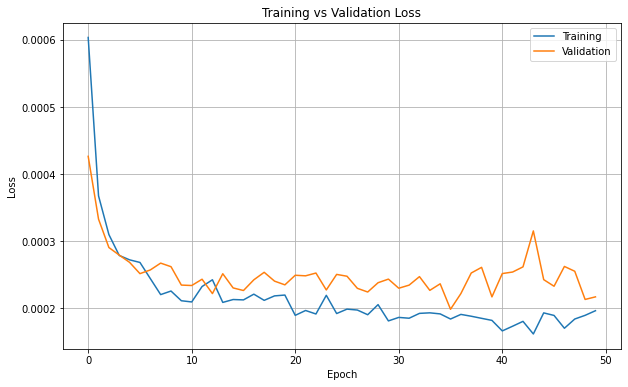

In [54]:
sets27 = combs[27][0]
model27 = FFNNA(sets27["x"]["test"].shape[1], 0.05, adamax, "relu")
model27.load("../saved_models/tuningPerMass2", f"FFNNA_tag2_comb27")
model27.plot_loss()

In [55]:
def f1scores_per_mass(model, sets, masses, th):
    for mass in masses:
        display(HTML(f"<h2>Xtohh {mass} Tag 2</h2>"))
        x_test_mass = sets[mass]["x_test"]
        y_test_mass = sets[mass]["y_test"]
        w_test_mass = sets[mass]["w_test"]

        eval = model.complete_evaluation(
            x_test_mass, y_test_mass, w_test_mass, th, save = False
        )

        print("Accuracy:", eval["weighted_accuracy"])
        display(pd.DataFrame(eval["weighted_class_report"]))
        plot_confidence_matrix(eval["weighted_cm"], 6, 6, '.1f')

Accuracy: 0.9743834541683557


,0,1,macro avg,weighted avg
precision,0.962264,1.000594,0.981429,0.975380
recall,1.000285,0.924588,0.962437,0.974383
f1-score,0.980907,0.961091,0.970999,0.974126
support,0.360450,0.187494,0.547944,0.547944


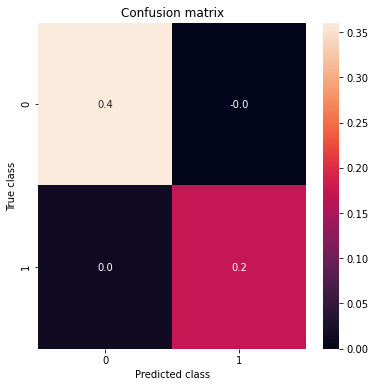

Accuracy: 0.9361583218690808


,0,1,macro avg,weighted avg
precision,0.870921,0.973110,0.922016,0.939174
recall,0.948309,0.930117,0.939213,0.936158
f1-score,0.907969,0.951128,0.929548,0.936795
support,0.496357,0.998274,1.494630,1.494630


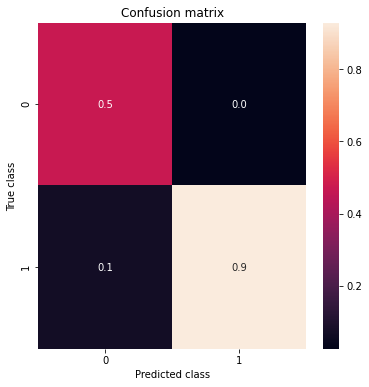

Accuracy: 0.952490998055618


,0,1,macro avg,weighted avg
precision,0.881360,0.981674,0.931517,0.954650
recall,0.951763,0.952760,0.952261,0.952491
f1-score,0.915209,0.967001,0.941105,0.953048
support,0.575024,1.559477,2.134501,2.134501


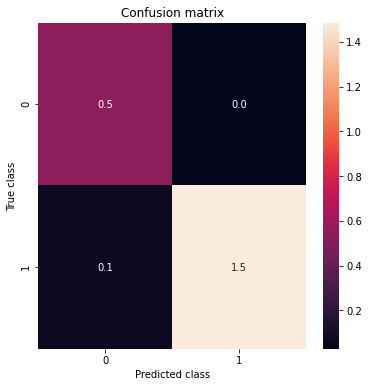

Accuracy: 0.9177061112281465


,0,1,macro avg,weighted avg
precision,0.724631,0.948786,0.836709,0.916377
recall,0.694905,0.955365,0.825135,0.917706
f1-score,0.709457,0.952064,0.830761,0.916987
support,0.312190,1.847002,2.159192,2.159192


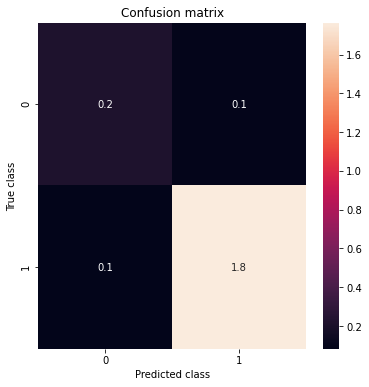

Accuracy: 0.9633082432512771


,0,1,macro avg,weighted avg
precision,0.842331,0.980931,0.911631,0.963780
recall,0.865494,0.977122,0.921308,0.963308
f1-score,0.853755,0.979023,0.916389,0.963521
support,0.278024,1.968723,2.246747,2.246747


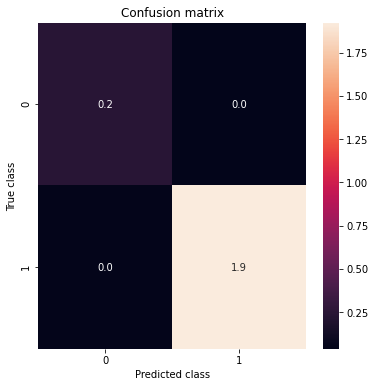

Accuracy: 0.9861147028378235


,0,1,macro avg,weighted avg
precision,0.905439,1.005361,0.955400,0.988367
recall,1.025450,0.978054,1.001752,0.986115
f1-score,0.961715,0.991519,0.976617,0.986451
support,0.397218,1.938392,2.335610,2.335610


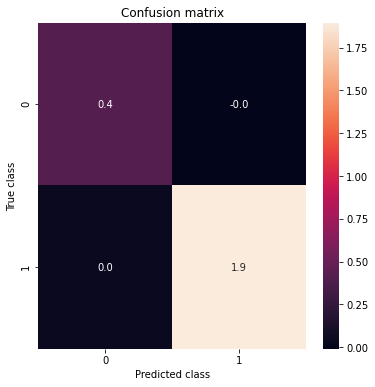

Accuracy: 0.9852696559224378


,0,1,macro avg,weighted avg
precision,0.966879,0.989965,0.978422,0.985241
recall,0.960934,0.991531,0.976233,0.985270
f1-score,0.963897,0.990747,0.977322,0.985253
support,0.397792,1.546116,1.943909,1.943909


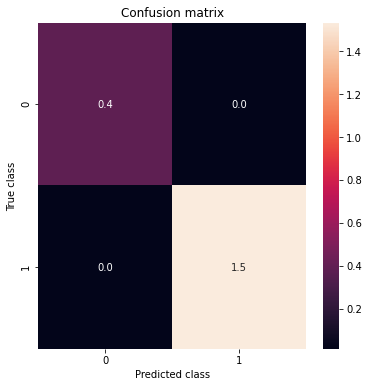

Accuracy: 0.9798589663530622


,0,1,macro avg,weighted avg
precision,0.974645,0.982958,0.978802,0.979849
recall,0.971425,0.984899,0.978162,0.979859
f1-score,0.973032,0.983928,0.978480,0.979852
support,0.541472,0.906135,1.447607,1.447607


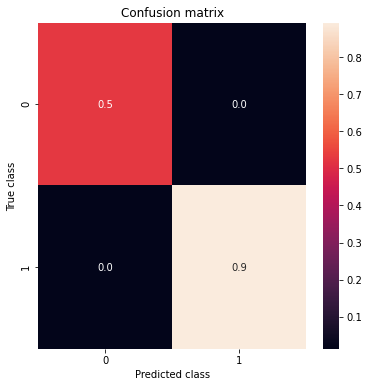

In [56]:
f1scores_per_mass(model27, sets27, masses, 0.7)lr